## Computation of confidence intervals using a grid search
Computing confidence intervals using a grid search is a method particularly useful when analytic solutions are unavailable. By evaluating the parameter space, calculating posterior probabilities for every point, and deriving credible intervals we get a confidence interval given the data and prior knowledge such that P[Θ ∈ I | X] = 1−α where alpha is our confidence level. In this manner  it is an analogue to a frequentist confidence interval.

By first creating a fine grid of plausible values for our parameters and defining a posterior, following bayesian inference, we can compute the value of the posterior in each point. Meaning that every combination of n parameters is used to calculate the posterior giving a hypercube filled with **m_1 \cdot m_2 \cdot ... \cdot m_n** points. (for ** m_i** the total number of chosen grid values).
 

To identify the confidence interval we have two main methods. For symmetric distributions we look at an equal tail approximation. The interval [θ(α/2),θ(1−α/2)] determines the region where all points lay such the probability for a point to lay in this interval is 1- alpha. This reflects the true probability the value of our parameter lies in that interval. However this brings some ambiguity into play. Imagine a simple gaussian distribution. we can construct a alpa =0.5 interval on the left side going from -inf to the mean or an interval on the right side. we can also have the mean in the middle of the interval and symmetrically go to both side. To solve this ambivalence we try to minimize the length of the interval. Or let the interval be determined by equalling the excluded area on both tail-ends. rtest



## Complete example
To illustrate bayesian inference using grid searches to determine confidence intervals and updating said posterior we will look at the density distribution of a astronomical object. For this we picked Supernova remnants. The distribution of these SNR's are directly related to the total amount of SNR in the milky way, which is still debated by researchers. One of the models of the density distribution of SNR is the sersic profile, also used for other applications. It originates from the Intensity profile of a galaxy for outgoing radii.  It has three parameter of which two are independant. r_e is the scale length for which the r=0 intensity has dropped to half its value,  n is the Sersic index controlling the curvature of the profile. b_n is determined by solving the eq. $$\gamma (2n,bn) = 0.5 \Gamma(2n)$$ or for n > 0.5 the approximation: $$ b(n) = 2n − \frac{1}{3} + \frac{4}{405n}  + \frac{46}{25515n^2}$$
giving the full profile the following form:
$$ \rho = \rho_0 \exp{ \left[-b_n \left( \frac{r}{r_e} \right)^{\frac{1}{n}}- 1 \right]} $$

source: https://arxiv.org/pdf/astro-ph/9911078 and https://arxiv.org/abs/2209.04570






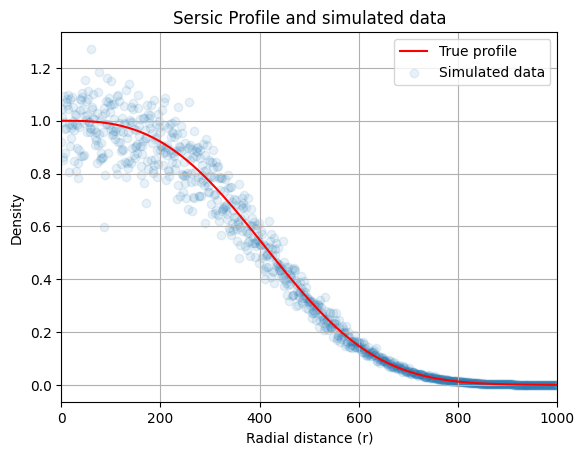

In [311]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from tqdm.notebook import tqdm
import numpy as np
import scipy.optimize as opt
import scipy.special as sp
import matplotlib.pyplot as plt

# -------------------- Step 1: Simulate SNR density distribution --------------------
np.random.seed(120847)

def sersic_profile(r, r_e, n):
    """Compute the Sérsic profile"""
    b_n = 2 * n - 1/3 +4/(405*n) + 46/(25515*n**2) # Approximation for b_n 
    rho = np.exp(-b_n * ((r / r_e)**(1/n) - 1))
    return rho / np.max(rho) 
   
def sim_data(r,r_e,n, fractional_uncertainty):
	y_true = sersic_profile(r,r_e,n)
	y_unc_true = np.abs(y_true)*fractional_uncertainty 
	y_sample = np.random.normal(y_true, y_unc_true, size=len(r))
	return y_sample, y_unc_true


R_max  = 1e3 
r_range = np.linspace(0,R_max,1000)

# True parameters
true_n = 0.35
true_r_e = 350

#simulating data
fractional_uncertainty = 0.1
sim_r, sim_r_uncertainty = sim_data(r_range, true_r_e , true_n, fractional_uncertainty)
# 
plt.figure()
plt.title("Sersic Profile and simulated data")
plt.plot(r_range, sersic_profile(r_range, true_r_e, true_n), c="red", label="True profile")
plt.scatter(r_range, sim_r, alpha=0.1, label="Simulated data")
plt.xlim(0,R_max)
plt.grid()
plt.xlabel("Radial distance (r)")
plt.ylabel("Density")
plt.legend()
plt.show()

After simulating some data we can start the bayesian inference. We start with step 1, choosing a prior. For now we will assume a flat prior which is around the true n value. From looking at different simulated sersic profiles such bounds could in practise be estimated. We then must choose a statistical model. We take for this the sersic profile and use a gaussian likelihood. 

In [317]:
# -------------------- Step 2: Define Prior and Likelihood --------------------
def flat_prior(n, r_e ):
    if 0.3<= n <= 0.4 and 325 <= r_e <= 375:  # Example bounds
        return 1
    return 0 

def log_likelihood(r, observed, sigma, r_e, n,):
    model_density = sersic_profile(r, r_e, n)
    return (-np.sum(0.5 * ((observed - model_density) / sigma) ** 2 + np.log(sigma * np.sqrt(2 * np.pi))))

def posterior(n_space, r_e_space, r_range, sim_r, sim_r_uncertainty, prior):
    log_posterior_grid = np.full((len(n_space),len(r_e_space)), -np.inf)
    
    # Loop over all combinations of n and r_e, filling in the grid with values of the posterior
    for i in tqdm(range(len(n_space))):
        for j in range(len(r_e_space)):
            prior_val = prior(n_space[i],r_e_space[j] )
            if prior_val == 0:
                continue
            else:
                # Compute likelihood for this position (using the simulated data)
                # Compute the posterior for this position,
                # i represents the n parameter (axis = 0), and j represents the r_e parameter (axis=1)
                log_likelihood_value = log_likelihood(r_range, sim_r, sim_r_uncertainty,r_e_space[j], n_space[i] )
                log_posterior_grid[i, j] = log_likelihood_value + np.log(prior_val)          
    posterior = np.exp(log_posterior_grid- np.max(log_posterior_grid))
    
    return  posterior


Step three of bayesian inference will be to calculate the posterior density. Since we are using a grid search we will do so for all combinations of  r_e and n as chosen in our grid below.

In [318]:
# Create a 2D grid of r_e and n,
n_space = np.linspace(0.1, 1, 10000)
r_e_space = np.linspace(1, R_max, 10000)
posterior_grid = posterior(n_space, r_e_space, r_range, sim_r, sim_r_uncertainty, flat_prior)


  0%|          | 0/10000 [00:00<?, ?it/s]


To get the best-fit parameters we will find the grid point with the highest normalized posterior value

In [319]:
posterior_grid /= np.sum(posterior_grid)  # Normalizing the grid 

#  best-fit parameters
max_idx = np.unravel_index(np.argmax(posterior_grid), posterior_grid.shape)
best_fit_n = n_space[max_idx[0]]
best_fit_r_e = r_e_space[max_idx[1]]

print(f"Best-fit n: {best_fit_n}")
print(f"Best-fit r_e: {best_fit_r_e}")  

Best-fit n: 0.35148514851485146
Best-fit r_e: 349.38613861386136


To get a feeling of how the posterior distribution of both parameters looks like we will plot both. To do so we will margenalise over one of the parameters as following: $$ P(r_e) = \Sigma_{n} P(r_e,n) $$.

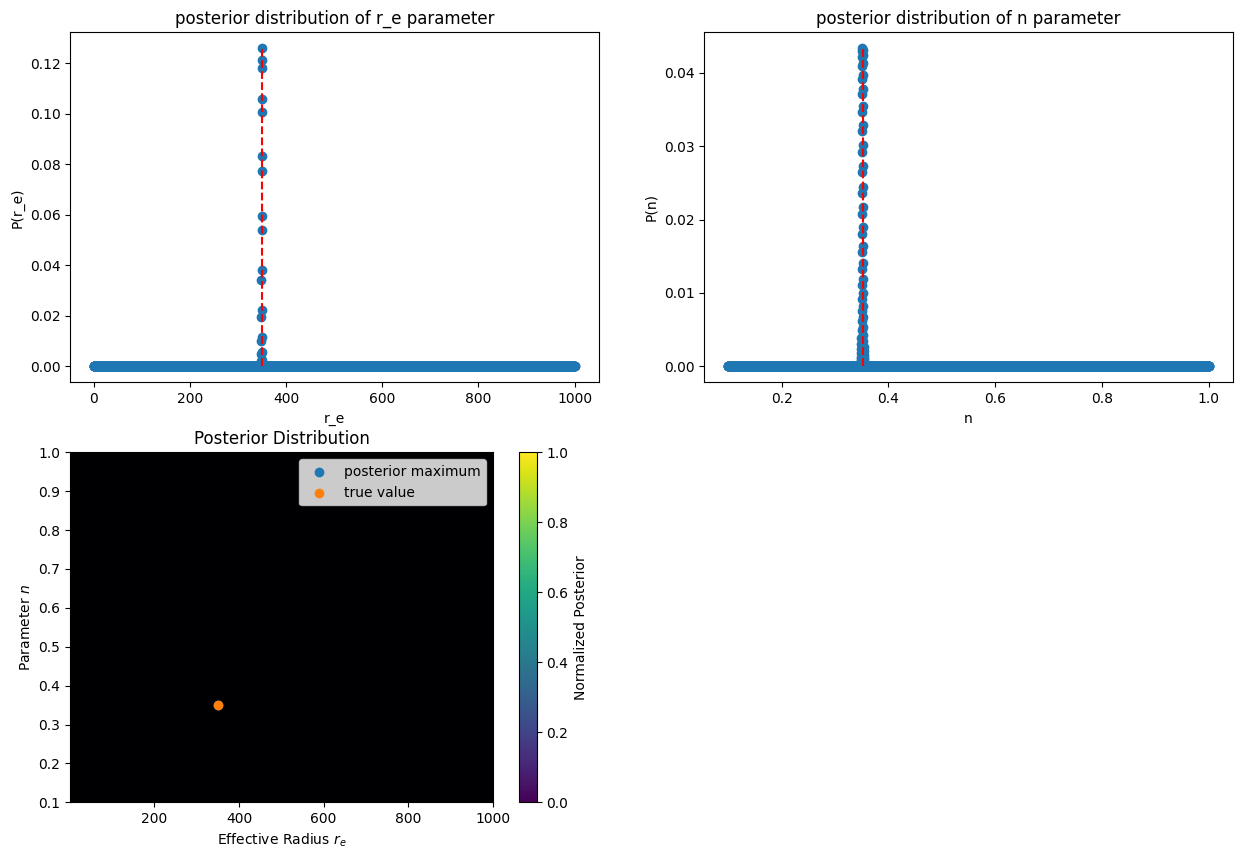

In [320]:
P_r_e = np.sum(posterior_grid, axis=0)
P_n = np.sum(posterior_grid, axis=1)

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.title("posterior distribution of r_e parameter")
plt.scatter(r_e_space, P_r_e)

plt.vlines(x= best_fit_r_e, ymin=np.min(P_r_e),ymax=np.max(P_r_e), color="r", linestyles="--")
plt.xlabel("r_e")
plt.ylabel("P(r_e)")


plt.subplot(2,2,2)
plt.title("posterior distribution of n parameter")
plt.scatter(n_space,P_n)
plt.vlines(x= best_fit_n,ymin=np.min(P_n),ymax=np.max(P_n), color="r", linestyles="--")
plt.xlabel("n")
plt.ylabel("P(n)")


plt.subplot(2,2,3)
plt.imshow(posterior_grid, extent=[r_e_space.min(), r_e_space.max(), n_space.min(), n_space.max()], origin='lower', aspect='auto', cmap='magma')
plt.scatter(best_fit_r_e, best_fit_n, label="posterior maximum")
plt.scatter(true_r_e,true_n, label="true value")
plt.colorbar(label="Normalized Posterior")
plt.title("Posterior Distribution")
plt.xlabel("Effective Radius $r_e$")
plt.ylabel("Parameter $n$")
plt.legend()
plt.show()


Notice the large fractional uncertainty in the first simulated set. If we are now in the future, having better equipment. we reduce the systematic error and increase the accuracy and prescision. 

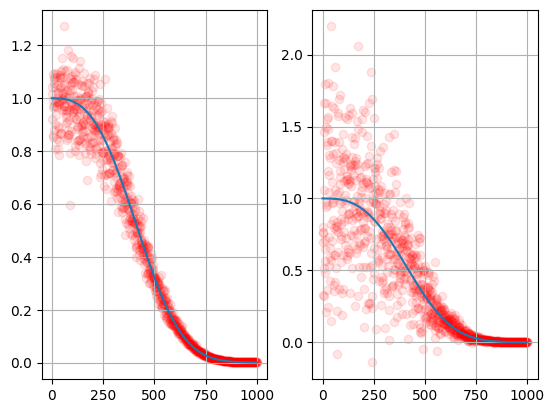

In [325]:
fractional_uncertainty = 0.4
sim_r_2, sim_r_uncertainty_2 = sim_data(r_range, true_r_e, true_n, fractional_uncertainty)

plt.figure()
plt.subplot(1,2,1)
plt.plot(r_range, sersic_profile(r_range, true_r_e, true_n))
plt.scatter(r_range, sim_r, alpha=0.1, c="red")

plt.grid()

plt.subplot(1,2,2)
plt.plot(r_range, sersic_profile(r_range, true_r_e, true_n))
plt.scatter(r_range, sim_r_2, alpha=0.1, c="red")

plt.grid()
plt.show()


In [326]:
def updated_prior(n, r_e ):
    if best_fit_n - 0.01 <= n <= best_fit_n + 0.01 and best_fit_r_e-2 <= r_e <= best_fit_r_e + 2: 
        return 1 
    return 0 

posterior_grid_2 = posterior(n_space, r_e_space, r_range, sim_r_2, sim_r_uncertainty_2, updated_prior)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [327]:
posterior_grid_2 /= np.sum(posterior_grid_2) 

posterior_grid_updated = posterior_grid_2 * posterior_grid
posterior_grid_updated /= np.sum(posterior_grid_updated)

#  best-fit parameters
max_idx = np.unravel_index(np.argmax(posterior_grid_2), posterior_grid_2.shape)
best_fit_n_2 = n_space[max_idx[0]]
best_fit_r_e_2 = r_e_space[max_idx[1]]

print(f"Best-fit n: {best_fit_n_2:.3f}")
print(f"Best-fit r_e: {best_fit_r_e_2:.3f}") 

max_idx = np.unravel_index(np.argmax(posterior_grid_updated), posterior_grid_updated.shape)
best_fit_n_updated = n_space[max_idx[0]]
best_fit_r_e_updated = r_e_space[max_idx[1]]
print('\n')
print(f"Best-fit n with update: {best_fit_n_updated:.3f}")
print(f"Best-fit r_e with update: {best_fit_r_e_updated:.3f}") 

Best-fit n: 0.346
Best-fit r_e: 350.585


Best-fit n with update: 0.351
Best-fit r_e with update: 349.486


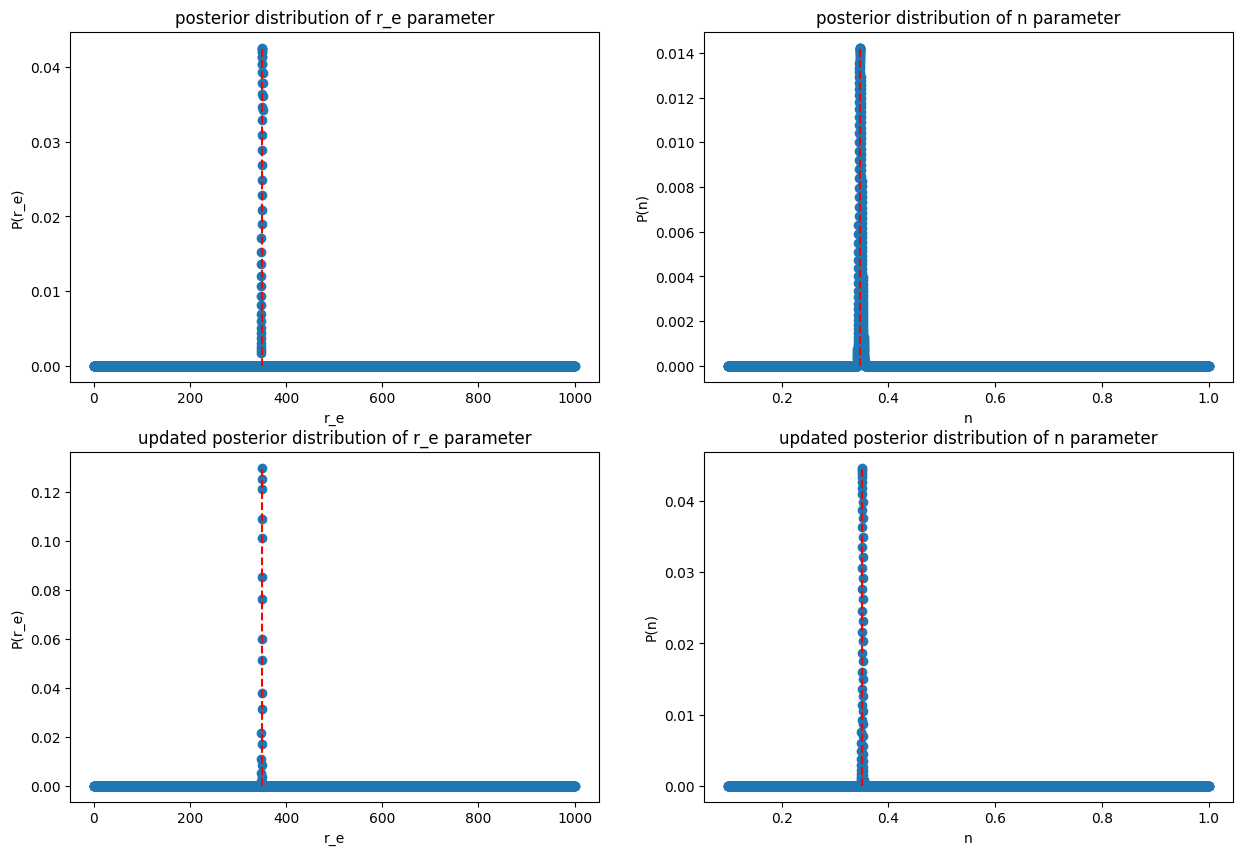

In [328]:
P_r_e_2 = np.sum(posterior_grid_2, axis=0)
P_n_2 = np.sum(posterior_grid_2, axis=1)

P_r_e_upd = np.sum(posterior_grid_updated, axis=0)
P_n_upd = np.sum(posterior_grid_updated, axis=1)

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.title("posterior distribution of r_e parameter")
plt.scatter(r_e_space, P_r_e_2)

plt.vlines(x= best_fit_r_e_2, ymin=np.min(P_r_e_2),ymax=np.max(P_r_e_2), color="r", linestyles="--")
plt.xlabel("r_e")
plt.ylabel("P(r_e)")


plt.subplot(2,2,2)
plt.title("posterior distribution of n parameter")
plt.scatter(n_space,P_n_2)
plt.vlines(x= best_fit_n_2,ymin=np.min(P_n_2),ymax=np.max(P_n_2), color="r", linestyles="--")
plt.xlabel("n")
plt.ylabel("P(n)")


plt.subplot(2,2,3)
plt.title("updated posterior distribution of r_e parameter")
plt.scatter(r_e_space, P_r_e_upd)

plt.vlines(x= best_fit_r_e_updated, ymin=np.min(P_r_e_upd),ymax=np.max(P_r_e_upd), color="r", linestyles="--")
plt.xlabel("r_e")
plt.ylabel("P(r_e)")


plt.subplot(2,2,4)
plt.title("updated posterior distribution of n parameter")
plt.scatter(n_space,P_n_upd)
plt.vlines(x= best_fit_n_updated,ymin=np.min(P_n_upd),ymax=np.max(P_n_upd), color="r", linestyles="--")
plt.xlabel("n")
plt.ylabel("P(n)")
plt.show()


In [329]:
def compute_equal_tailed_interval(parameter_space, posterior, alpha=0.05):
    cdf = np.cumsum(posterior)
    lower_bound = parameter_space[np.searchsorted(cdf, alpha / 2)]
    upper_bound = parameter_space[np.searchsorted(cdf, 1 - alpha / 2)]
    return lower_bound, upper_bound

def find_minimal_interval(parameter_space, posterior, alpha):
    # Normalize posterior to ensure it sums to 1
    posterior = posterior / np.sum(posterior)

    # Initialize variables
    min_width = np.inf
    best_interval = None
    target_prob =  1-alpha
    
    # Sliding window
    for i in tqdm(range(len(parameter_space)), desc="Parameter space"):  # Start of the window
        cumulative_prob = 0  # Reset cumulative probability for each new starting point
        
        for j in range(i, len(parameter_space)):  # End of the window
            # Expand the window by adding the probability at j
            cumulative_prob += posterior[j]

            # Check if the window meets or exceeds the target probability
            if cumulative_prob >= target_prob:
                # Calculate the width of the current window
                width = parameter_space[j] - parameter_space[i]

                # If the current window's width is smaller, update the best interval
                if width < min_width:
                    min_width = width
                    best_interval = (round(parameter_space[i], 3), round(parameter_space[j], 3))

                # No need to continue further as we want to minimize the width
                break  # Move to the next starting point (i)

    return best_interval

In [330]:

P_r_e = np.sum(posterior_grid_updated, axis=0)
P_n = np.sum(posterior_grid_updated, axis=1)


# Normalize the marginalized distributions
n_mag = P_n /  np.sum(P_n)
r_e_mag = P_r_e /  np.sum(P_r_e)

# Compute confidence intervals (# 95% confidence)
alpha = 0.22
n_lower, n_upper = compute_equal_tailed_interval(n_space, n_mag, alpha)
r_e_lower, r_e_upper = compute_equal_tailed_interval(r_e_space, r_e_mag, alpha)
print(f"95% confidence interval for n: [{n_lower:.3f}, {n_upper:.3f}]")
print(f"95% confidence interval for r_e: [{r_e_lower:.3f}, {r_e_upper}:.3")

# Find minimal-width intervals for n and r_e
n_min_interval = find_minimal_interval(n_space, n_mag, alpha)
r_e_min_interval = find_minimal_interval(r_e_space, r_e_mag, alpha)

print(f"Minimal-width interval for n with 5% confidence: {n_min_interval}")
print(f"Minimal-width interval for r_e with 5% confidence: {r_e_min_interval}")


95% confidence interval for n: [0.350, 0.352]
95% confidence interval for r_e: [349.086, 349.8856885688569:.3


Parameter space:   0%|          | 0/10000 [00:00<?, ?it/s]

Parameter space:   0%|          | 0/10000 [00:00<?, ?it/s]

Minimal-width interval for n with 5% confidence: (np.float64(0.35), np.float64(0.352))
Minimal-width interval for r_e with 5% confidence: (np.float64(349.086), np.float64(349.786))


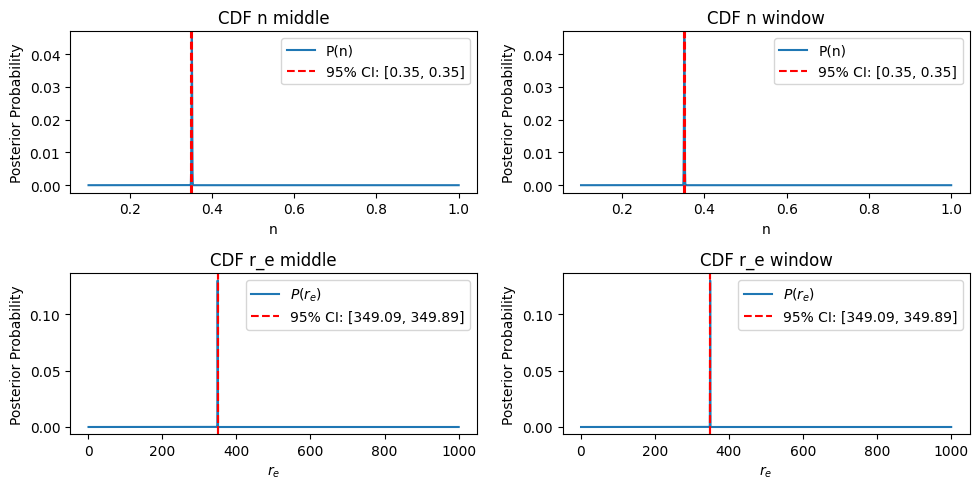

In [331]:
plt.figure(figsize=(10, 5))

# Marginalized n
plt.subplot(2, 2, 1)
plt.plot(n_space, n_mag, label='P(n)')
plt.title("CDF n middle")
plt.axvline(n_lower, color='r', linestyle='--', label=f"95% CI: [{n_lower:.2f}, {n_upper:.2f}]")
plt.axvline(n_upper, color='r', linestyle='--')
plt.xlabel("n")
plt.ylabel("Posterior Probability")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(n_space, n_mag, label='P(n)')
plt.title("CDF n window")
plt.axvline(n_min_interval[0], color='r', linestyle='--', label=f"95% CI: [{n_lower:.2f}, {n_upper:.2f}]")
plt.axvline(n_min_interval[1], color='r', linestyle='--')
plt.xlabel("n")
plt.ylabel("Posterior Probability")
plt.legend()

# Marginalized r_e
plt.subplot(2, 2, 3)
plt.title("CDF r_e middle")
plt.plot(r_e_space, r_e_mag, label=r'$P(r_e)$')
plt.axvline(r_e_lower, color='r', linestyle='--', label=f"95% CI: [{r_e_lower:.2f}, {r_e_upper:.2f}]")
plt.axvline(r_e_upper, color='r', linestyle='--')
plt.xlabel(r"$r_e$")
plt.ylabel("Posterior Probability")
plt.legend()

plt.subplot(2, 2, 4)
plt.title("CDF r_e window")
plt.plot(r_e_space, r_e_mag, label=r'$P(r_e)$')
plt.axvline(r_e_min_interval[0], color='r', linestyle='--', label=f"95% CI: [{r_e_lower:.2f}, {r_e_upper:.2f}]")
plt.axvline(r_e_min_interval[1], color='r', linestyle='--')
plt.xlabel(r"$r_e$")
plt.ylabel("Posterior Probability")
plt.legend()

plt.tight_layout()
plt.show()  